In [16]:
import numpy as np
import os
import cv2 as cv
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
real_data = "SOCOFing/Real"
altered_data = "SOCOFing/Altered"

Sokoto Coventry Fingerprint Dataset (SOCOFing) is a biometric fingerprint database designed for academic research purposes. SOCOFing is made up of 6,000 fingerprint images from 600 African subjects and contains unique attributes such as labels for gender, hand and finger name as well as synthetically altered versions with three different levels of alteration for obliteration, central rotation, and z-cut. For a complete formal description and usage policy please refer to the following paper: https://arxiv.org/abs/1807.10609

In [17]:
data = []
labels = []

df = pd.DataFrame(columns=['id', 'image', 'label'])
# load the real data and their labels
photos_names = os.listdir(real_data)

i = 0
for name in photos_names:
    img = cv.imread(os.path.join(real_data ,name) ,cv.IMREAD_GRAYSCALE)
    data.append(img)
    labels.append(0)
    
    df.loc[i, 'id'] = name.split('_')[0]
    df.loc[i, 'image'] = img
    df.loc[i, 'label'] = 0
    i += 1

In [18]:
# load the altered data and their labels
dirs = ["Altered-Easy" ,"Altered-Hard" ,"Altered-Medium"]
for folder in dirs:
    photos_names = os.listdir(os.path.join(altered_data ,folder))
    for name in photos_names:
        img = cv.imread(os.path.join(altered_data ,folder ,name) ,cv.IMREAD_GRAYSCALE)
        data.append(img)
        labels.append(1)
        
        df.loc[i, 'id'] = name.split('_')[0]
        df.loc[i, 'image'] = img
        df.loc[i, 'label'] = 1
        i += 1
        

In [19]:
x = 96
y = 103

In [20]:
train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True, stratify=df['id'])
# train_data, test_data, train_labels, test_labels  = train_test_split(data, labels, test_size=0.2, random_state=42)

train_data = train['image'].values
train_labels = train['label'].values

test_data = test['image'].values
test_labels = test['label'].values

In [21]:
# resizing all the data to 103X96
# for i,image in enumerate(data):
#     data[i] = cv.resize(image ,(x,y))
    
# data = np.stack(data).reshape(-1 ,y ,x ,1)
# labels = np.stack(labels).reshape(-1 ,1)

# remake the code above for the train and test data
for i,image in enumerate(train_data):
    train_data[i] = cv.resize(image ,(x,y))

train_data = np.stack(train_data).reshape(-1 ,y ,x ,1)
train_labels = np.stack(train_labels).reshape(-1 ,1)

for i,image in enumerate(test_data):
    test_data[i] = cv.resize(image ,(x,y))

test_data = np.stack(test_data).reshape(-1 ,y ,x ,1)
test_labels = np.stack(test_labels).reshape(-1 ,1)

In [22]:
# printing shapes
train_data.shape ,train_labels.shape ,test_data.shape ,test_labels.shape

((44216, 103, 96, 1), (44216, 1), (11054, 103, 96, 1), (11054, 1))

In [23]:
# print the shape of the data for each image with different shape than expected
i = 0
for image in train_data:
    if image.shape != (y, x, 1):
        i += 1
print('images without the correct shape: ', i)

images without the correct shape:  0


[1]


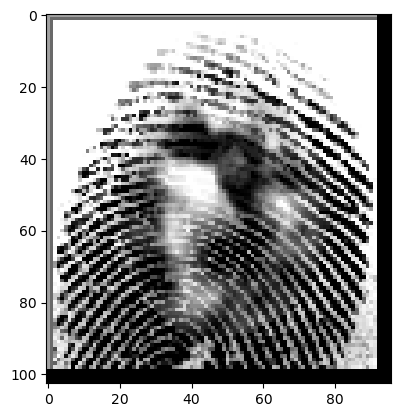

In [24]:
# visualization of 1 image from train data
import matplotlib.pyplot as plt
print(train_labels[0])
plt.imshow(train_data[0], cmap='gray')
plt.show()

In [25]:
# converting numpy arrays to tensors
train_data_tensor = tf.convert_to_tensor(train_data, dtype=tf.float16)
test_data_tensor = tf.convert_to_tensor(test_data, dtype=tf.float16)
train_labels_tensor = tf.convert_to_tensor(train_labels, dtype=tf.int16)
test_labels_tensor = tf.convert_to_tensor(test_labels, dtype=tf.int16)

# converting to 3 channels
train_data_3 = tf.image.grayscale_to_rgb(train_data_tensor)
test_data_3 = tf.image.grayscale_to_rgb(test_data_tensor)

ResourceExhaustedError: {{function_node __wrapped__Tile_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[44216,103,96,3] and type half on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Tile]

### Using Cross Entropy loss

In [11]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Flatten, Dense
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(y, x, 3))
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  
predictions = Dense(1, activation='sigmoid')(x)  

# Creating model combining the base of ResNet50 and the new custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Visualizing the network architecture
# model.summary()

model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train_data_3, train_labels_tensor, epochs=10, batch_size=32, validation_split=0.2)



Epoch 1/10
1106/1106 [==============================] - 39s 30ms/step - loss: 0.5237 - accuracy: 0.9005 - val_loss: 0.1904 - val_accuracy: 0.9110
Epoch 2/10
1106/1106 [==============================] - 32s 29ms/step - loss: 0.1785 - accuracy: 0.9177 - val_loss: 0.1847 - val_accuracy: 0.9167
Epoch 3/10
1106/1106 [==============================] - 32s 29ms/step - loss: 0.1684 - accuracy: 0.9228 - val_loss: 0.1988 - val_accuracy: 0.9043
Epoch 4/10
1106/1106 [==============================] - 35s 31ms/step - loss: 0.1575 - accuracy: 0.9273 - val_loss: 0.1772 - val_accuracy: 0.9181
Epoch 5/10
1106/1106 [==============================] - 35s 32ms/step - loss: 0.1489 - accuracy: 0.9338 - val_loss: 0.1756 - val_accuracy: 0.9213
Epoch 6/10
1106/1106 [==============================] - 36s 33ms/step - loss: 0.1407 - accuracy: 0.9358 - val_loss: 0.1732 - val_accuracy: 0.9211
Epoch 7/10
1106/1106 [==============================] - 39s 35ms/step - loss: 0.1319 - accuracy: 0.9402 - val_loss: 0.1726 -

In [12]:
y_pred = model.predict(test_data_3)


print("Balanced Accuracy: " +  str(balanced_accuracy_score(test_labels_tensor, np.rint(y_pred))))
print("Confusion Matrix: \n" +  str(confusion_matrix(test_labels_tensor, np.rint(y_pred))))
print(classification_report(test_labels_tensor, np.rint(y_pred)))

346/346 [==============================] - 10s 24ms/step
Balanced Accuracy: 0.8139547184004352
Confusion Matrix: 
[[ 820  390]
 [ 490 9354]]
              precision    recall  f1-score   support

           0       0.63      0.68      0.65      1210
           1       0.96      0.95      0.96      9844

    accuracy                           0.92     11054
   macro avg       0.79      0.81      0.80     11054
weighted avg       0.92      0.92      0.92     11054



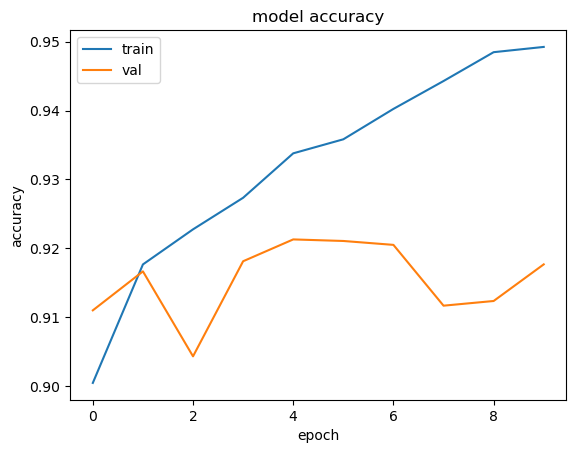

In [13]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Using Binary Accuracy metric

In [11]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Flatten, Dense
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(y, x, 3))
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  
predictions = Dense(1, activation='sigmoid')(x)  

# Creating model combining the base of ResNet50 and the new custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Visualizing the network architecture
# model.summary()

tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)

model.compile(optimizer='adam', loss="binary_crossentropy", metrics=[tf.keras.metrics.BinaryAccuracy()])
history = model.fit(train_data_3, train_labels_tensor, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
1106/1106 [==============================] - 43s 31ms/step - loss: 0.5158 - binary_accuracy: 0.8992 - val_loss: 0.1850 - val_binary_accuracy: 0.9188
Epoch 2/10
1106/1106 [==============================] - 32s 29ms/step - loss: 0.1760 - binary_accuracy: 0.9199 - val_loss: 0.1884 - val_binary_accuracy: 0.9126
Epoch 3/10
1106/1106 [==============================] - 32s 29ms/step - loss: 0.1664 - binary_accuracy: 0.9239 - val_loss: 0.1751 - val_binary_accuracy: 0.9205
Epoch 4/10
1106/1106 [==============================] - 33s 30ms/step - loss: 0.1608 - binary_accuracy: 0.9272 - val_loss: 0.1795 - val_binary_accuracy: 0.9167
Epoch 5/10
1106/1106 [==============================] - 35s 31ms/step - loss: 0.1547 - binary_accuracy: 0.9292 - val_loss: 0.1786 - val_binary_accuracy: 0.9206
Epoch 6/10
1106/1106 [==============================] - 38s 35ms/step - loss: 0.1458 - binary_accuracy: 0.9344 - val_loss: 0.1714 - val_binary_accuracy: 0.9222
Epoch 7/10
1106/1106 [==================

In [14]:
y_pred = model.predict(test_data_3)


print("Balanced Accuracy: " +  str(balanced_accuracy_score(test_labels_tensor, np.rint(y_pred))))
print("Confusion Matrix: \n" +  str(confusion_matrix(test_labels_tensor, np.rint(y_pred))))
print(classification_report(test_labels_tensor, np.rint(y_pred)))

346/346 [==============================] - 7s 21ms/step
Balanced Accuracy: 0.7419093226230015
Confusion Matrix: 
[[ 625  585]
 [ 322 9522]]
              precision    recall  f1-score   support

           0       0.66      0.52      0.58      1210
           1       0.94      0.97      0.95      9844

    accuracy                           0.92     11054
   macro avg       0.80      0.74      0.77     11054
weighted avg       0.91      0.92      0.91     11054



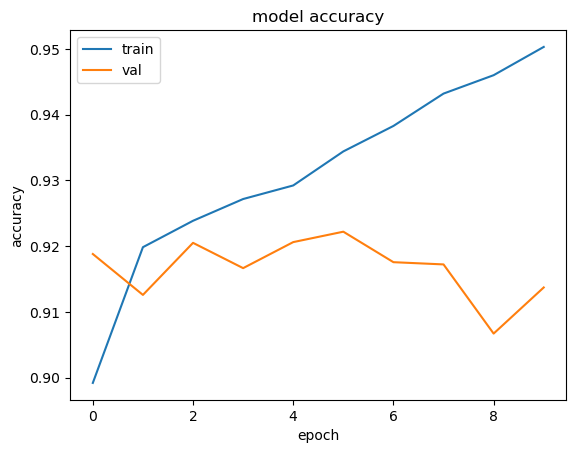

In [15]:
from matplotlib import pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Using Image Random Flip

In [26]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Flatten, Dense, RandomFlip
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(y, x, 3))
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
x = RandomFlip("horizontal")(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  
predictions = Dense(1, activation='sigmoid')(x)  

# Creating model combining the base of ResNet50 and the new custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Visualizing the network architecture
# model.summary()

tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)

model.compile(optimizer='adam', loss="binary_crossentropy", metrics=[tf.keras.metrics.BinaryAccuracy()])
history = model.fit(train_data_3, train_labels_tensor, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1106/1106 [==============================] - 50s 41ms/step - loss: 0.5489 - binary_accuracy: 0.8956 - val_loss: 0.1888 - val_binary_accuracy: 0.9138
Epoch 2/10
1106/1106 [==============================] - 43s 39ms/step - loss: 0.1749 - binary_accuracy: 0.9191 - val_loss: 0.1768 - val_binary_accuracy: 0.9188
Epoch 3/10
1106/1106 [==============================] - 42s 38ms/step - loss: 0.1695 - binary_accuracy: 0.9241 - val_loss: 0.1834 - val_binary_accuracy: 0.9159
Epoch 4/10
1106/1106 [==============================] - 45s 40ms/step - loss: 0.1619 - binary_accuracy: 0.9260 - val_loss: 0.1894 - val_binary_accuracy: 0.9169
Epoch 5/10
1106/1106 [==============================] - 42s 38ms/step - loss: 0.1612 - binary_accuracy: 0.9262 - val_loss: 0.1825 - val_binary_accuracy: 0.9163
Epoch 6/10
1106/1106 [==============================] - 43s 39ms/step - loss: 0.1480 - binary_accuracy: 0.9337 - val_loss: 0.2583 - val_binary_accuracy: 0.9038
Epoch 7/10
1106/1106 [==================

In [27]:
y_pred = model.predict(test_data_3)


print("Balanced Accuracy: " +  str(balanced_accuracy_score(test_labels_tensor, np.rint(y_pred))))
print("Confusion Matrix: \n" +  str(confusion_matrix(test_labels_tensor, np.rint(y_pred))))
print(classification_report(test_labels_tensor, np.rint(y_pred)))

346/346 [==============================] - 8s 20ms/step
Balanced Accuracy: 0.6669481095167253
Confusion Matrix: 
[[ 427  783]
 [ 187 9657]]
              precision    recall  f1-score   support

           0       0.70      0.35      0.47      1210
           1       0.93      0.98      0.95      9844

    accuracy                           0.91     11054
   macro avg       0.81      0.67      0.71     11054
weighted avg       0.90      0.91      0.90     11054



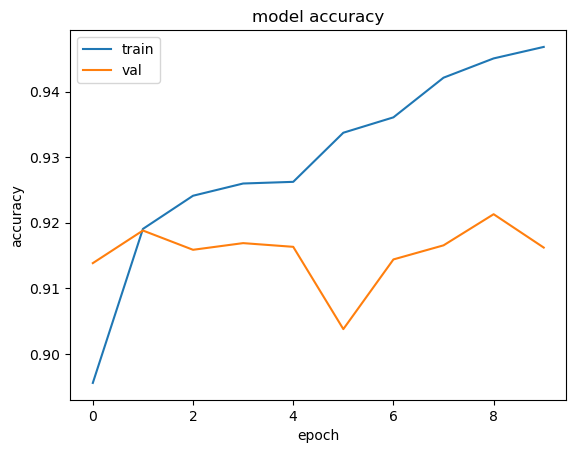

In [28]:
from matplotlib import pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Using Binary Focal loss

In [29]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Flatten, Dense, RandomRotation, RandomFlip, RandomZoom


base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(y, x, 3))
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
# x = RandomFlip("horizontal")(x)
# x = RandomZoom(0.2)(x)
# x = RandomRotation(0.2)(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  
predictions = Dense(1, activation='sigmoid')(x)  

# Creating model combining the base of ResNet50 and the new custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Visualizing the network architecture
# model.summary()

TypeError: Keras symbolic inputs/outputs do not implement `__len__`. You may be trying to pass Keras symbolic inputs/outputs to a TF API that does not register dispatching, preventing Keras from automatically converting the API call to a lambda layer in the Functional Model. This error will also get raised if you try asserting a symbolic input/output directly.

In [ ]:
tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0), metrics=[tf.keras.metrics.BinaryAccuracy()])
history = model.fit(train_data_3, train_labels_tensor, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
553/553 [==============================] - 46s 73ms/step - loss: 0.6083 - binary_accuracy: 0.8857 - val_loss: 0.1479 - val_binary_accuracy: 0.8912
Epoch 2/10
553/553 [==============================] - 40s 72ms/step - loss: 0.0493 - binary_accuracy: 0.9199 - val_loss: 0.0577 - val_binary_accuracy: 0.9088
Epoch 3/10
553/553 [==============================] - 40s 71ms/step - loss: 0.0407 - binary_accuracy: 0.9296 - val_loss: 0.1395 - val_binary_accuracy: 0.8918
Epoch 4/10
553/553 [==============================] - 40s 72ms/step - loss: 0.0387 - binary_accuracy: 0.9324 - val_loss: 0.0647 - val_binary_accuracy: 0.9039
Epoch 5/10
553/553 [==============================] - 40s 72ms/step - loss: 0.0368 - binary_accuracy: 0.9367 - val_loss: 0.0647 - val_binary_accuracy: 0.8890
Epoch 6/10
553/553 [==============================] - 40s 72ms/step - loss: 0.0359 - binary_accuracy: 0.9360 - val_loss: 0.0752 - val_binary_accuracy: 0.9016
Epoch 7/10
553/553 [==============================] 

In [ ]:
y_pred = model.predict(test_data_3)

346/346 [==============================] - 10s 26ms/step


In [ ]:
a= np.rint(y_pred)

unique, counts = np.unique(a, return_counts=True)

dict(zip(unique, counts))

{0.0: 1764, 1.0: 9290}

In [ ]:
# calculate the balanced accuracy
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(balanced_accuracy_score(test_labels_tensor, np.rint(y_pred)))
print("Confusion Matrix: \n" +  str(confusion_matrix(test_labels_tensor, np.rint(y_pred))))
print(classification_report(test_labels_tensor, np.rint(y_pred)))

0.7930292747952842
Confusion Matrix: 
[[ 832  390]
 [ 932 8900]]
              precision    recall  f1-score   support

           0       0.47      0.68      0.56      1222
           1       0.96      0.91      0.93      9832

    accuracy                           0.88     11054
   macro avg       0.71      0.79      0.74     11054
weighted avg       0.90      0.88      0.89     11054



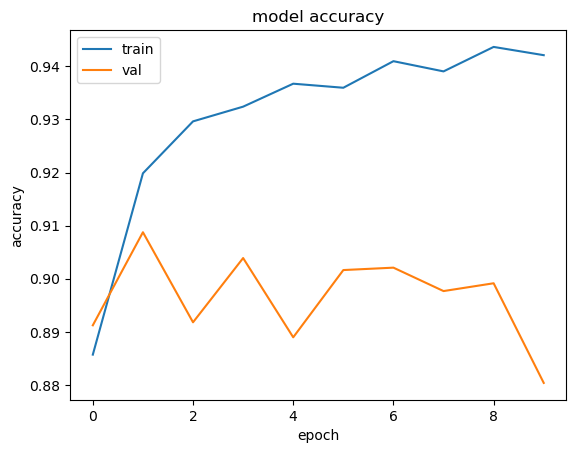

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Using Balanced Classes

In [ ]:
import random

data = []
labels = []
random.seed(42)

# load the real data and their labels
photos_names = os.listdir(real_data)
for name in photos_names:
    data.append(cv.imread(os.path.join(real_data ,name) ,cv.IMREAD_GRAYSCALE))
    labels.append(0)

# load the altered data and their labels
dirs = ["Altered-Easy" ,"Altered-Hard" ,"Altered-Medium"]
limit = int((len(data)*1.2)/len(dirs))
for folder in dirs:
    dir_list = os.listdir(os.path.join(altered_data ,folder))
    photos_names = random.choices(population=dir_list, k=limit)
    for name in photos_names:
        data.append(cv.imread(os.path.join(altered_data ,folder ,name) ,cv.IMREAD_GRAYSCALE))
        labels.append(1)


In [ ]:
x = 96
y = 103

In [ ]:
# resizeing all the data to 103X96
for i,image in enumerate(data):
    data[i] = cv.resize(image ,(x,y))
    
data = np.stack(data).reshape(-1 ,y ,x ,1)
labels = np.stack(labels).reshape(-1 ,1)

In [ ]:
train_data, test_data, train_labels, test_labels  = train_test_split(data, labels, test_size=0.2, random_state=42)

In [ ]:
# converting numpy arrays to tensors
train_data_tensor = tf.convert_to_tensor(train_data, dtype=tf.float16)
test_data_tensor = tf.convert_to_tensor(test_data, dtype=tf.float16)
train_labels_tensor = tf.convert_to_tensor(train_labels, dtype=tf.int16)
test_labels_tensor = tf.convert_to_tensor(test_labels, dtype=tf.int16)

# converting to 3 channels
train_data_3 = tf.image.grayscale_to_rgb(train_data_tensor)
test_data_3 = tf.image.grayscale_to_rgb(test_data_tensor)

In [ ]:
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Flatten, Dense, RandomRotation, RandomFlip, RandomZoom

# passar pra 3 canais
# incluir uma camada que faça a classificacao
# flatten
# densa
# classificacao

base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(y, x, 3))
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
# x = RandomFlip("horizontal")(x)
# x = RandomZoom(0.2)(x)
# x = RandomRotation(0.2)(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  
predictions = Dense(1, activation='sigmoid')(x)  

# Creating model combining the base of ResNet50 and the new custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Visualizing the network architecture
# model.summary()

In [ ]:
tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)

model.compile(optimizer='adam', loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0), metrics=[tf.keras.metrics.BinaryAccuracy()])
history = model.fit(train_data_3, train_labels_tensor, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
264/264 [==============================] - 13s 40ms/step - loss: 1.4094 - binary_accuracy: 0.7984 - val_loss: 0.2411 - val_binary_accuracy: 0.7618
Epoch 2/10
264/264 [==============================] - 10s 37ms/step - loss: 0.1223 - binary_accuracy: 0.8632 - val_loss: 0.1497 - val_binary_accuracy: 0.8068
Epoch 3/10
264/264 [==============================] - 10s 37ms/step - loss: 0.0704 - binary_accuracy: 0.8996 - val_loss: 0.0879 - val_binary_accuracy: 0.8679
Epoch 4/10
264/264 [==============================] - 10s 39ms/step - loss: 0.0557 - binary_accuracy: 0.9148 - val_loss: 0.0821 - val_binary_accuracy: 0.8759
Epoch 5/10
264/264 [==============================] - 10s 38ms/step - loss: 0.0485 - binary_accuracy: 0.9242 - val_loss: 0.1270 - val_binary_accuracy: 0.8191
Epoch 6/10
264/264 [==============================] - 10s 36ms/step - loss: 0.0458 - binary_accuracy: 0.9278 - val_loss: 0.0876 - val_binary_accuracy: 0.8807
Epoch 7/10
264/264 [==============================] 

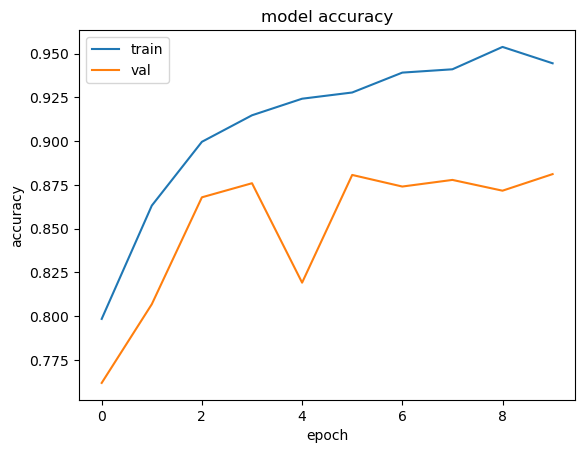

In [ ]:
from matplotlib import pyplot as plt

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

y_pred = model.predict(test_data_3)

print("Balanced Accuracy: " +  str(balanced_accuracy_score(test_labels_tensor, np.rint(y_pred))))
print("Confusion Matrix: \n" +  str(confusion_matrix(test_labels_tensor, np.rint(y_pred))))
print(classification_report(test_labels_tensor, np.rint(y_pred)))

83/83 [==============================] - 3s 28ms/step
Balanced Accuracy: 0.8692200007989481
Confusion Matrix: 
[[1010  187]
 [ 152 1291]]
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      1197
           1       0.87      0.89      0.88      1443

    accuracy                           0.87      2640
   macro avg       0.87      0.87      0.87      2640
weighted avg       0.87      0.87      0.87      2640



In [ ]:
model.save('socoF.h5') 